# Modeling differential expression between cell types in single cell RNA-seq data 

In order to simulate a **mixture** of cell types in single cell RNA-seq, we must first accurately model differential expression between cell types. Here, we explore and compare various models for doing so using externally and internally-annotated single cell RNA-seq data. 

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sc
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools
import statsmodels.graphics.gofplots

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Data description

We consider the following datasets:

* 10x Genomics: 68k PBMCs
* HGSC: 5' GE from VOA11543SA (a particularly good sample with lots of cells)

Cell type assignments in the 68k PBMC data were annotated in XXXX, and our data was annotated with CellAssign (selecting cells with >90% probability for that given cell type). 

In [2]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+\\/]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

pbmc_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc68k_markers.feather')
pbmc_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc_68k_normal_logfcs.feather')

voa11543sa_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/VOA11543SA_markers.feather')
voa11543sa_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/VOA11543SA_normal_logfcs.feather')

# Models


## null

See below. We fit the null model to bootstrap resamples. 

In [3]:
def run_null_model(nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        sd_null = pm.Gamma('sd_null', alpha = .1, beta = 1.)
        b_null = pm.Gamma('b_null', alpha = 1., beta = .1)
        
        dispersed_prob = pm.Beta('dispersed_prob', alpha = 1., beta = 1.)

        pm.Mixture('null',
                  comp_dists = [pm.Normal.dist(mu = 0., sd = sd_null),
                               pm.Laplace.dist(mu = 0., b = b_null)],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})


## `splatter`

The current gold-standard, the `splatter` model for simulating synthetic single cell RNA-seq data (see https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1305-0), generates data for multiple cell populations as follows:

1. Generate $C$ populations at relative proportions $\theta$
2. $de\_prob_{i}$ genes are differentially expressed in population $i$ (compared to baseline)
3. If a gene is differentially expressed:
    * its fold change, equivalent to $\exp(\delta_{gc})$ from the `CellAssign` model, is drawn from $\text{Lognormal}(\mu_{i}, \sigma_{i})$, where $\mu_{i} > 0$
    * a certain proportion of DE'd genes (`down_prob`) are drawn from a separate lognormal with mean $-\mu_i$ (and the same $\sigma_i$)
4. Otherwise, its fold change is set to 0
5. Counts are simulated from a negative binomial given these fold change values and the other `splatter` parameters

When drawing fold changes, it is entirely possible that a gene that's supposed to be upregulated (i.e. drawn from the lognormal with positive mean) gets a fold change of $< 1$. In this case, `splatter` uses the reciprocal of the fold change instead (or equivalently, the negative of the logFC). The same applies for upregulated genes that are supposed to be downregulated.

To model this we construct a bit of a perverse model in `pymc3` -- we consider logFC's instead, and draw the positive and negative components from an absolute value-transformed `Normal`. This isn't straightforward to do in `pymc3`, but since we can easily compute the cdf of any Gaussian and $\text{Normal}(\mu,\sigma)$ and $\text{Normal}(-\mu,\sigma)$ are reflections over 0, we can treat each absolute value-Gaussian as a mixture of 2 Gaussians, as follows:

In [4]:
def zvalue(value, sd=1, mu=0):
    """
    Calculate the z-value for a normal distribution. By default standard normal.
    """
    return (value - mu) / tt.sqrt(2. * sd ** 2.)

def cdf(mu, sd, value):
    z = zvalue(value, mu=mu, sd=sd)
    return tt.erfc(-z / tt.sqrt(2.))/2.

In [5]:
def splatter_model(observations, nulls, null_sd, null_b, null_dispersed_prob, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd_pos = pm.Gamma('sd_pos', alpha = 1., beta = 1.)
        sd_neg = pm.Gamma('sd_neg', alpha = 1., beta = 1.)
        
        dispersed_prob = null_dispersed_prob
        spike_component = pm.Normal.dist(mu = 0., sd = null_sd) 
        slab_component = pm.Laplace.dist(mu = 0., b = null_b)

        # Sample from Gaussian-Laplace mixture for null (spike-and-slab mixture)
        pm.Mixture('null',
                  comp_dists = [spike_component,
                               slab_component],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)
        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd_pos)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd_neg)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd_pos)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd_neg)
        
        cdf_pos = cdf(mu = mu_pos, sd = sd_pos, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd_neg, value = 0.)

        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob) * (1.-dispersed_prob),
                                    (1.-de_prob) * dispersed_prob, 
                                    de_prob * (1.-down_prob) * (1.-cdf_pos), 
                                    de_prob * down_prob * cdf_neg,
                                    de_prob * (1.-down_prob) * cdf_pos, 
                                    de_prob * down_prob * (1.-cdf_neg)]),
                  comp_dists = [spike_component,
                                slab_component, 
                                pos_component, 
                                neg_component, 
                                pos_component_abs,
                                neg_component_abs],
                  observed = observations)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})

## Our model

We modify the `splatter` method by considering the following generative process for **log**FC values:

We draw logFC values from the following mixture:

* A null component (set to have all probability mass at 0 for simulations; but fitted as a Gaussian + Laplace mixture to bootstrap-derived logFC's from real data)
* A positively-displaced component, $\text{StudentT}(\mu_{+,i}, \sigma_{+,i}, \nu_{+,i})$ bounded to be $\geq 0$
* A negatively-displaced component, $\text{StudentT}(\mu_{-,i}, \sigma_{-,i}, \nu_{-,i})$, bounded to be $\leq 0$

The rationale for this model comes from the observation that the `splatter` model does not appear to fit outlying logFC values well (underestimating them). This is particularly problematic for `CellAssign` because those outlying genes can serve as terrific marker genes.

In [6]:
def v2_model(observations, nulls, null_sd, null_b, null_dispersed_prob, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Beta('de_prob', alpha = 1., beta = 5.)
        
        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)
        
        dispersed_prob = null_dispersed_prob

        mu_pos = pm.Lognormal('mu_pos', mu = -3, sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = -3, sd = 1.) 
        sd_pos = pm.Gamma('sd_pos', alpha = 0.01, beta = 1.) 
        sd_neg = pm.Gamma('sd_neg', alpha = 0.01, beta = 1.) 
        nu_pos = pm.Gamma('nu_pos', alpha = 5., beta = 1.)
        nu_neg = pm.Gamma('nu_neg', alpha = 5., beta = 1.)
        
        spike_component = pm.Normal.dist(mu = 0., sd = null_sd)
        slab_component = pm.Laplace.dist(mu = 0., b = null_b)

        # Sample from Gaussian-Laplace mixture for null (spike-and-slab mixture)
        pm.Mixture('null',
                  comp_dists = [spike_component,
                               slab_component],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)
    
        pos_component = pm.Bound(pm.StudentT, lower = 0.).dist(mu = mu_pos, sd = sd_pos, nu = nu_pos)
        neg_component = pm.Bound(pm.StudentT, upper = 0.).dist(mu = -mu_neg, sd = sd_neg, nu = nu_neg)
    
        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob) * (1.-dispersed_prob),
                                    (1.-de_prob) * dispersed_prob,
                                    de_prob * (1.-down_prob),
                                   de_prob * down_prob]),
                  comp_dists = [spike_component, slab_component, pos_component, neg_component],
                  observed = observations)


        pm.Deterministic('log_prob', model.logpt)
        
        for RV in model.basic_RVs:
            print(RV.name, RV.logp(model.test_point))

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})

In [7]:
def v3_model(observations, nulls, null_sd, null_b, null_dispersed_prob, iter_count = 2000, tune_iters = 2000, max_fc = 100):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Beta('de_prob', alpha = 1., beta = 5.)
        
        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)
        
        dispersed_prob = null_dispersed_prob

        mu_pos = pm.Lognormal('mu_pos', mu = -3, sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = -3, sd = 1.) 
        sd_pos = pm.Gamma('sd_pos', alpha = 0.01, beta = 1.) 
        sd_neg = pm.Gamma('sd_neg', alpha = 0.01, beta = 1.) 
        nu_pos = pm.Gamma('nu_pos', alpha = 5., beta = 1.)
        nu_neg = pm.Gamma('nu_neg', alpha = 5., beta = 1.)
        
        spike_component = pm.Normal.dist(mu = 0., sd = null_sd)
        slab_component = pm.Laplace.dist(mu = 0., b = null_b)

        # Sample from Gaussian-Laplace mixture for null (spike-and-slab mixture)
        pm.Mixture('null',
                  comp_dists = [spike_component,
                               slab_component],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)
    
        pos_component = pm.Bound(pm.StudentT, lower = 0., upper = np.log(max_fc)).dist(mu = mu_pos, sd = sd_pos, nu = nu_pos)
        neg_component = pm.Bound(pm.StudentT, upper = 0., lower = -np.log(max_fc)).dist(mu = -mu_neg, sd = sd_neg, nu = nu_neg)
    
        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob) * (1.-dispersed_prob),
                                    (1.-de_prob) * dispersed_prob,
                                    de_prob * (1.-down_prob),
                                   de_prob * down_prob]),
                  comp_dists = [spike_component, slab_component, pos_component, neg_component],
                  observed = observations)


        pm.Deterministic('log_prob', model.logpt)
        
        for RV in model.basic_RVs:
            print(RV.name, RV.logp(model.test_point))

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})

# 68k PBMCs: naive CD4+ vs. naive CD8+

Our first comparison will be naive CD4+ T cells vs. naive CD8+ T cells from the 68k PBMC data. 

In [10]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(pbmc_markers, class1, class2)
logfcs_same = np.array(pbmc_null_logfcs[(pbmc_null_logfcs['celltype'] == class1) & (pbmc_null_logfcs['permutation'] == 1)].logfc)

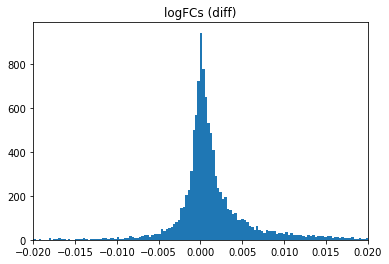

In [11]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

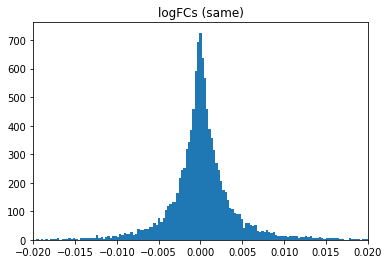

In [12]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

The bottom plot represents the null distribution of logFC's (using bootstrap resamples from naive CD8+'s), and the top plot shows the logFC's for all genes.

## Fitting null parameters

We first need to fit null parameters $\sigma$ (for the Normal component), $b$ (for the Laplace component), and `dispersed_prob` (the contribution of the Laplace component relative to the Normal one).

In [9]:
pbmc_cd4_cd8_null = run_null_model(logfcs_same, iter_count=4000, tune_iters = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dispersed_prob, b_null, sd_null]
100%|██████████| 4000/4000 [00:10<00:00, 378.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f653c953518>,
      dtype=object)

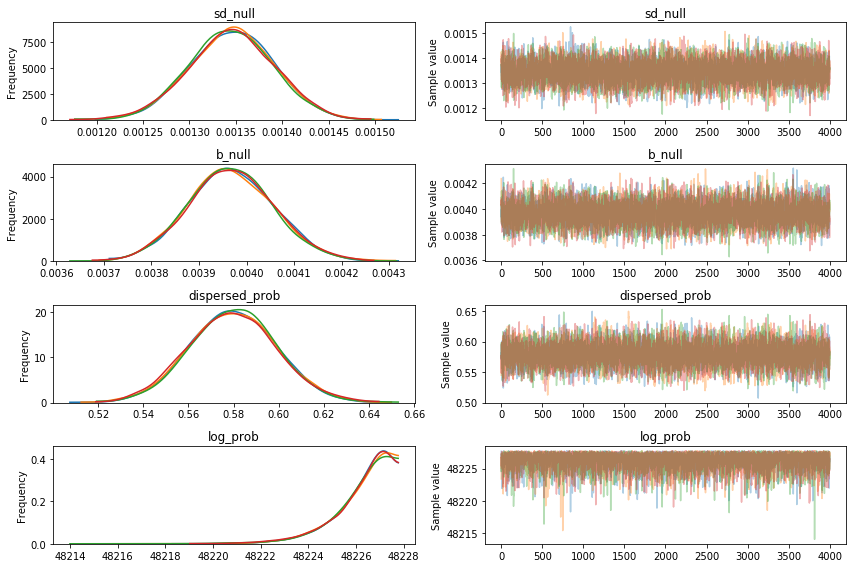

In [11]:
pm.traceplot(pbmc_cd4_cd8_null['trace'])

Next we'll make a QQ plot of random samplings from the posterior predictive and our true "null" observations.

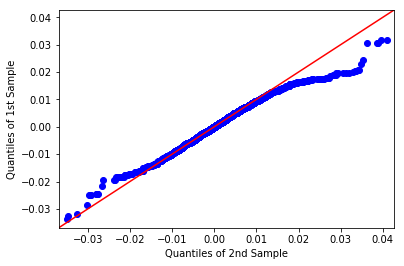

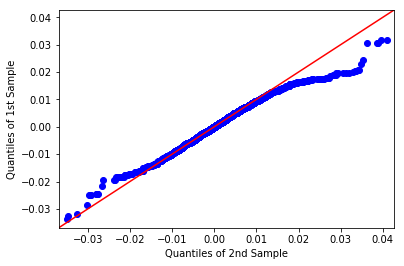

In [22]:
pred_samples = np.random.choice(pbmc_cd4_cd8_null['ppc']['null'].flatten(), size = logfcs_same.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_same, line = '45')

This fits fairly well. 

## Fitting `splatter`

We'll fit the `splatter` model based on the MAP estimates of the null parameters. 

In [31]:
pbmc_cd4_cd8_splatter = splatter_model(logfcs_diff, logfcs_same, null_sd = 0.00135, null_b = 0.004, null_dispersed_prob = 0.58, iter_count = 1000, tune_iters = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64c6677e10>,
      dtype=object)

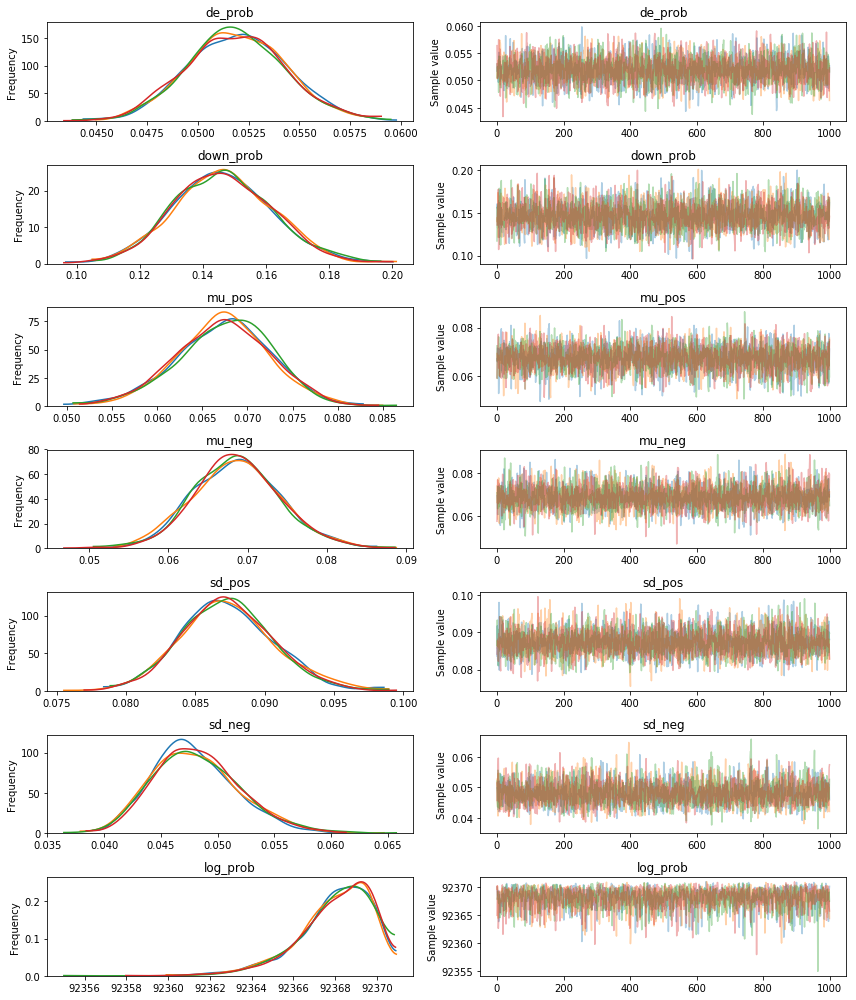

In [32]:
pm.traceplot(pbmc_cd4_cd8_splatter['trace'])

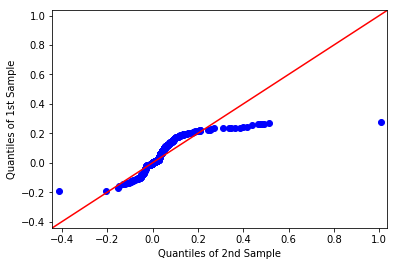

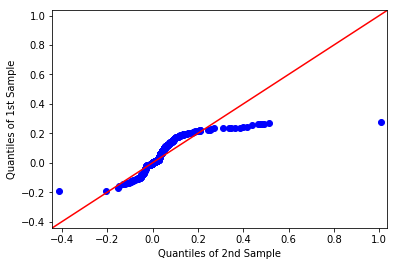

In [39]:
pred_samples = np.random.choice(pbmc_cd4_cd8_splatter['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

Here, sample 1 corresponds to the posterior predictive samples; sample 2 is `logfcs_diff`. The distribution generated from the splatter model is narrower than the observed logFCs. 

## Fitting v2 model

We'll fit our model next, based on those same MAP estimates.

In [108]:
pbmc_cd4_cd8_v2 = v2_model(logfcs_diff, logfcs_same, null_sd = 0.00135, null_b = 0.004, null_dispersed_prob = 0.58, iter_count = 2500, tune_iters = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 48239.6644703143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs 43239.388564728266


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 2500/2500 [00:23<00:00, 107.30it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64b6787550>,
      dtype=object)

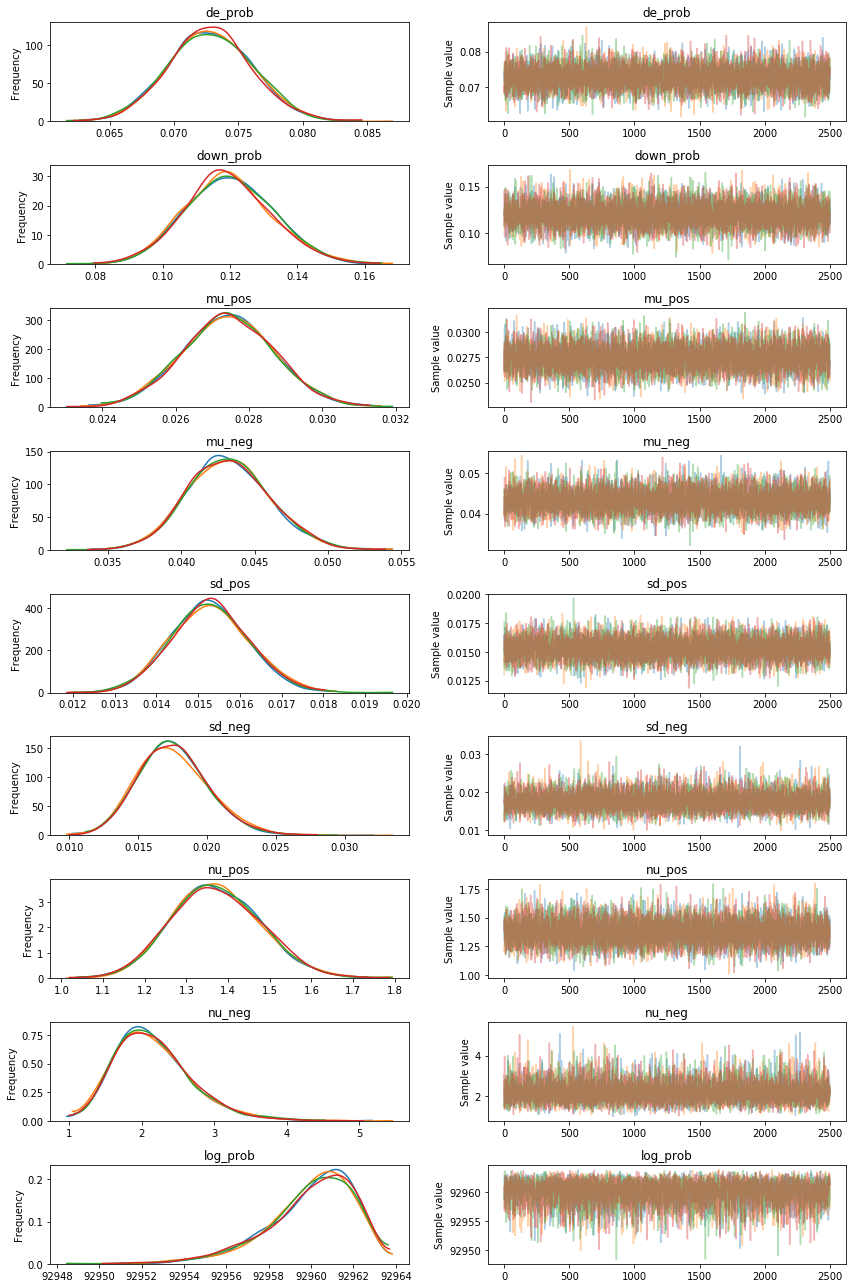

In [109]:
pm.traceplot(pbmc_cd4_cd8_v2['trace'])

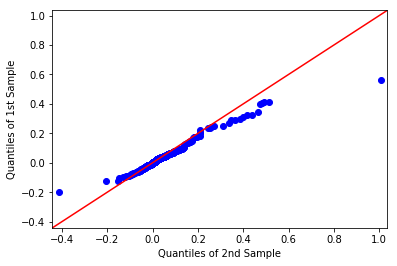

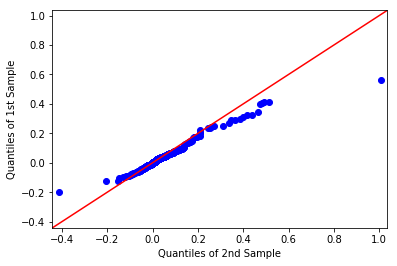

In [116]:
pred_samples = np.random.choice(pbmc_cd4_cd8_v2['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

There's still a bit of underestimation at the extremes, but this isn't nearly as bad.

## V3 model

In [45]:
pbmc_cd4_cd8_v3 = v3_model(logfcs_diff, logfcs_same, null_sd = 0.00135, null_b = 0.004, null_dispersed_prob = 0.58, iter_count = 2500, tune_iters = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 48239.6644703143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs 43239.388564728266


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 2500/2500 [00:22<00:00, 109.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd42e1519e8>,
      dtype=object)

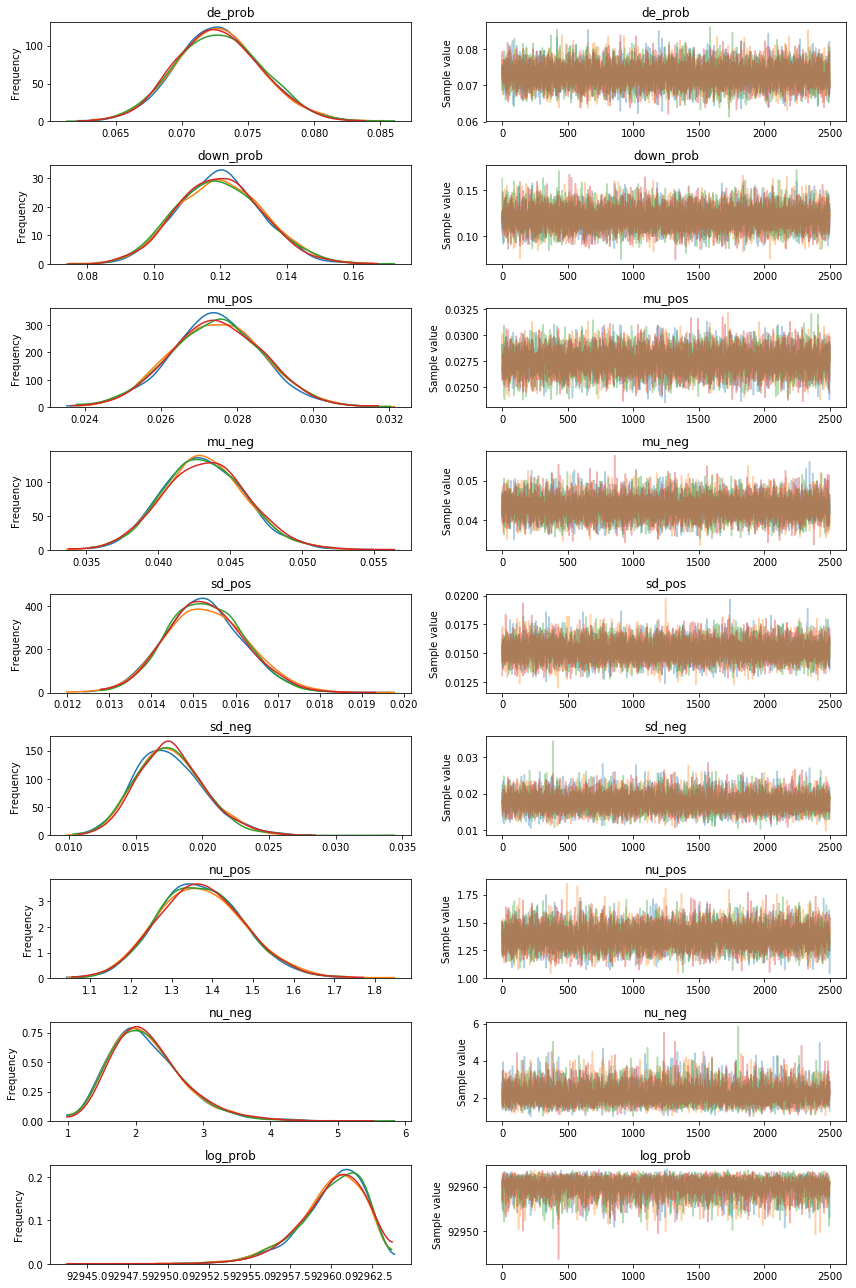

In [48]:
pm.traceplot(pbmc_cd4_cd8_v3['trace'])

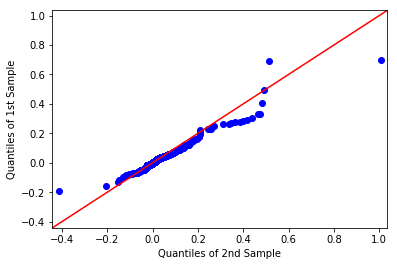

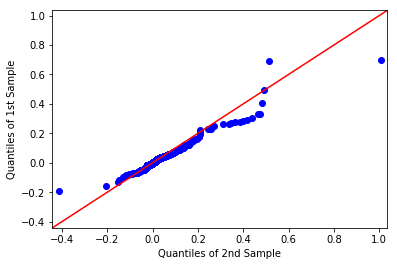

In [71]:
pred_samples = np.random.choice(pbmc_cd4_cd8_v3['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

In [83]:
np.min(pbmc_cd4_cd8_v3['ppc']['obs'])

-1.1740340804777696

# 68k PBMCs: B vs. CD8+

We'll next do a comparison for two cell types that are a little more divergent: B cells and CD8+ T cells.

In [118]:
class1 = "B"
class2 = "CD8+"

logfcs_diff = get_logfcs_comparison(pbmc_markers, class1, class2)
logfcs_same = np.array(pbmc_null_logfcs[(pbmc_null_logfcs['celltype'] == class2) & (pbmc_null_logfcs['permutation'] == 1)].logfc)

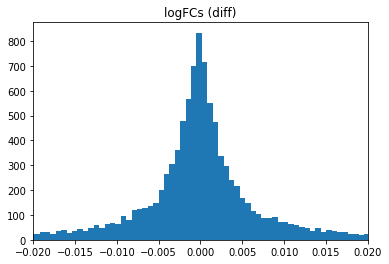

In [119]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

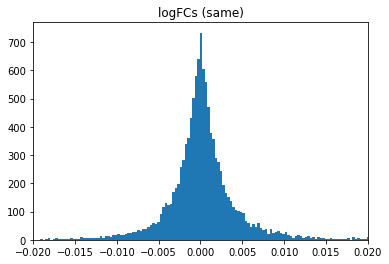

In [120]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

## Fitting null parameters

In [124]:
pbmc_b_cd8_null = run_null_model(logfcs_same, iter_count=4000, tune_iters = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dispersed_prob, b_null, sd_null]
100%|██████████| 4000/4000 [00:09<00:00, 400.41it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64bc408b70>,
      dtype=object)

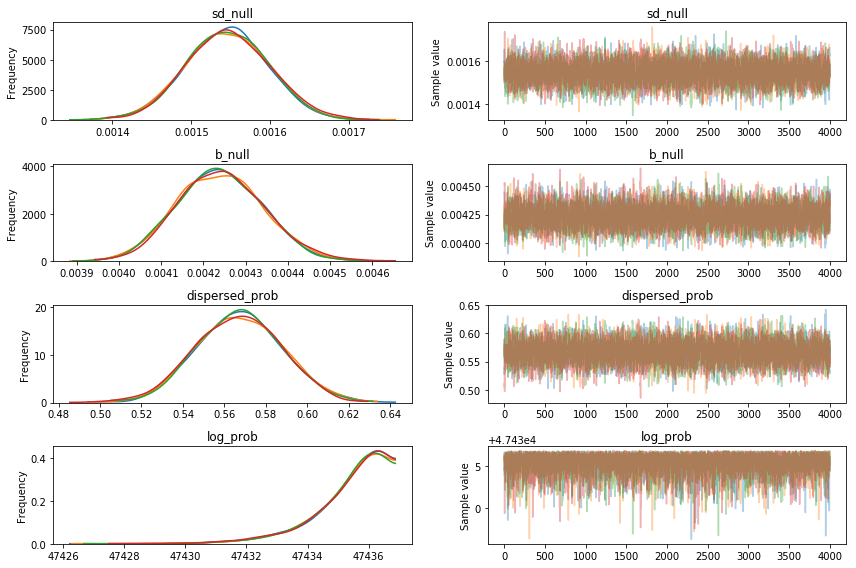

In [125]:
pm.traceplot(pbmc_b_cd8_null['trace'])

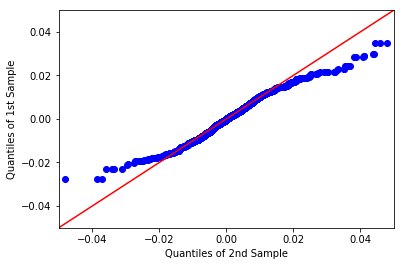

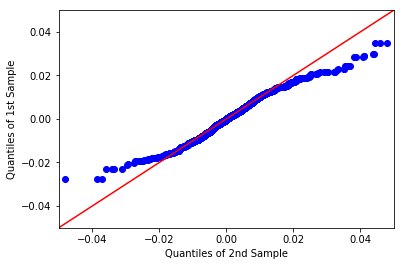

In [126]:
pred_samples = np.random.choice(pbmc_b_cd8_null['ppc']['null'].flatten(), size = logfcs_same.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_same, line = '45')

## Fitting `splatter` model

In [127]:
pbmc_b_cd8_splatter = splatter_model(logfcs_diff, logfcs_same, null_sd = 0.00155, null_b = 0.0042, null_dispersed_prob = 0.57, iter_count = 1000, tune_iters = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 1000/1000 [00:20<00:00, 48.60it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64a3e505c0>,
      dtype=object)

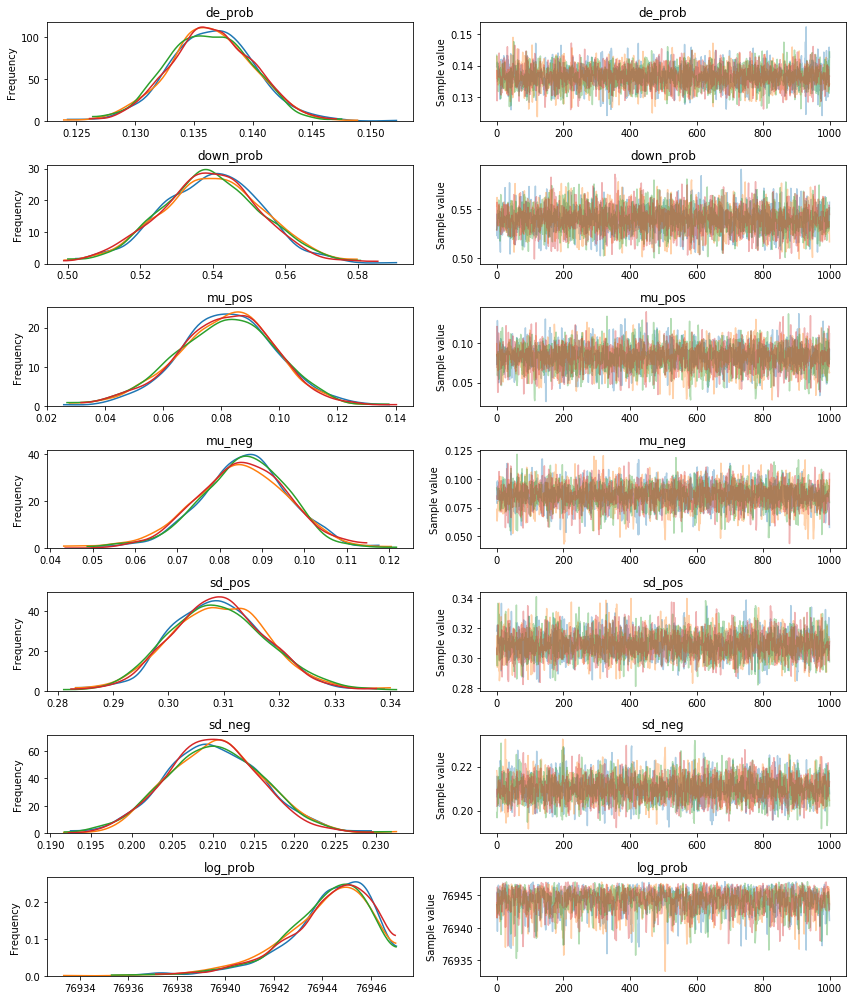

In [128]:
pm.traceplot(pbmc_b_cd8_splatter['trace'])

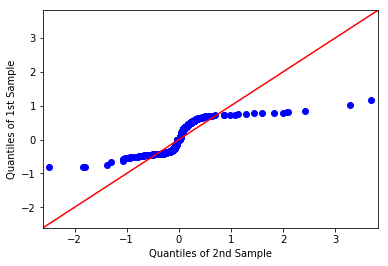

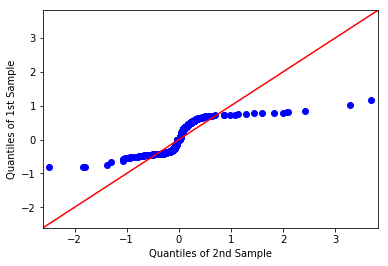

In [129]:
pred_samples = np.random.choice(pbmc_b_cd8_splatter['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

Ugh. This is really bad.

## Fitting v2 model

In [154]:
pbmc_b_cd8_v2 = v2_model(logfcs_diff, logfcs_same, null_sd = 0.00155, null_b = 0.0042, null_dispersed_prob = 0.57, iter_count = 2500, tune_iters = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 47452.38699576775


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs 28397.796390007432


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 2500/2500 [00:23<00:00, 108.01it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64b7551cf8>,
      dtype=object)

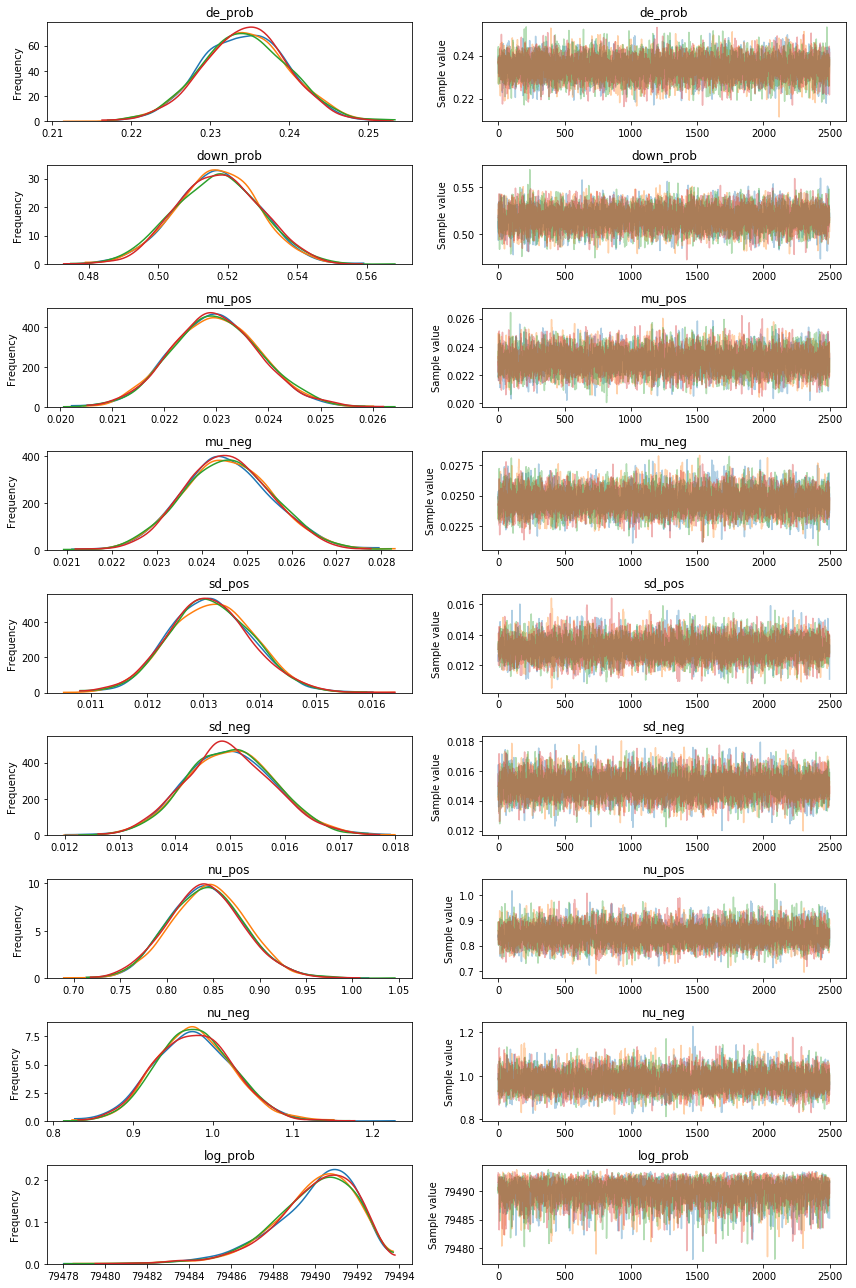

In [155]:
pm.traceplot(pbmc_b_cd8_v2['trace'])

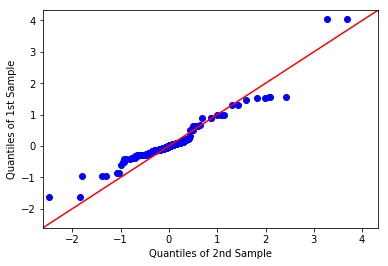

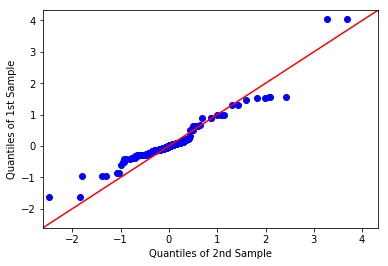

In [188]:
pred_samples = np.random.choice(pbmc_b_cd8_v2['ppc']['obs'][2000:2500].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

## V3 model

In [84]:
pbmc_b_cd8_v3 = v3_model(logfcs_diff, logfcs_same, null_sd = 0.00155, null_b = 0.0042, null_dispersed_prob = 0.57, iter_count = 2500, tune_iters = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 48212.016211828566


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs 43126.88061399795


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 2500/2500 [00:23<00:00, 108.67it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd406012588>,
      dtype=object)

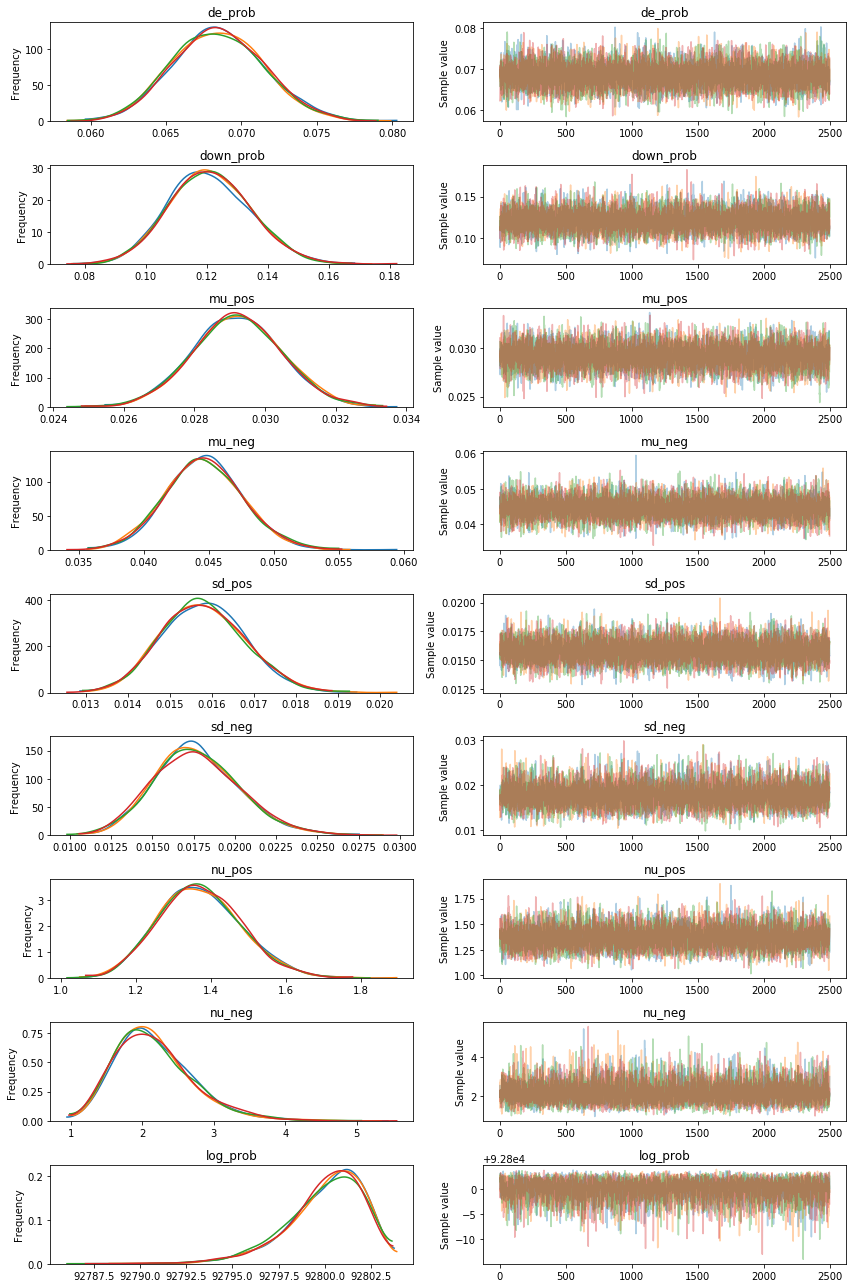

In [85]:
pm.traceplot(pbmc_b_cd8_v3['trace'])

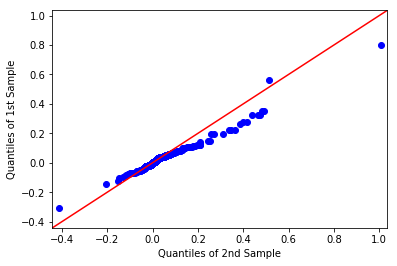

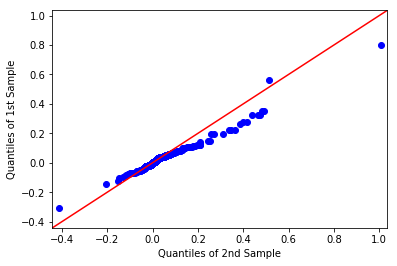

In [115]:
pred_samples = np.random.choice(pbmc_b_cd8_v3['ppc']['obs'][2000:2500].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

# HGSC: Monocytes/macrophages vs. CD8+ T cells

Next, we'll look at a different dataset: our in-house HGSC dataset. Note that these cell types were assigned by `CellAssign`, not manually annotated. 

In [116]:
class2 = "Monocyte/Macrophage"
class1 = "Cytotoxic T cells"

logfcs_diff = get_logfcs_comparison(voa11543sa_markers, class1, class2)
logfcs_same = np.array(voa11543sa_null_logfcs[(voa11543sa_null_logfcs['celltype'] == class1) & (voa11543sa_null_logfcs['permutation'] == 1)].logfc)

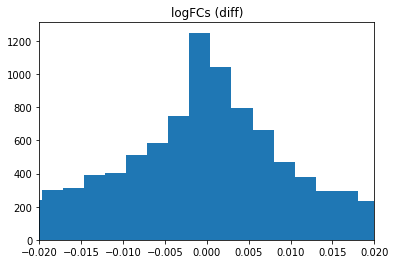

In [117]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

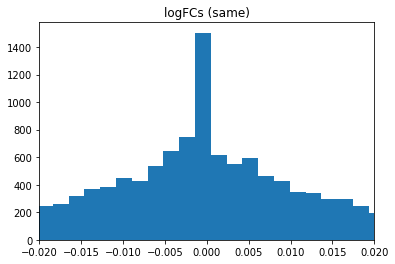

In [118]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

## Fitting null model

In [247]:
voa11543sa_mono_cd8_null = run_null_model(logfcs_same, iter_count=4000, tune_iters = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dispersed_prob, b_null, sd_null]
Sampling 4 chains: 100%|██████████| 24000/24000 [03:31<00:00, 43.51draws/s]
There were 3342 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2785 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2968 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3137 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 4000/4000 [00:10<00:00, 374.76it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6479efca58>,
      dtype=object)

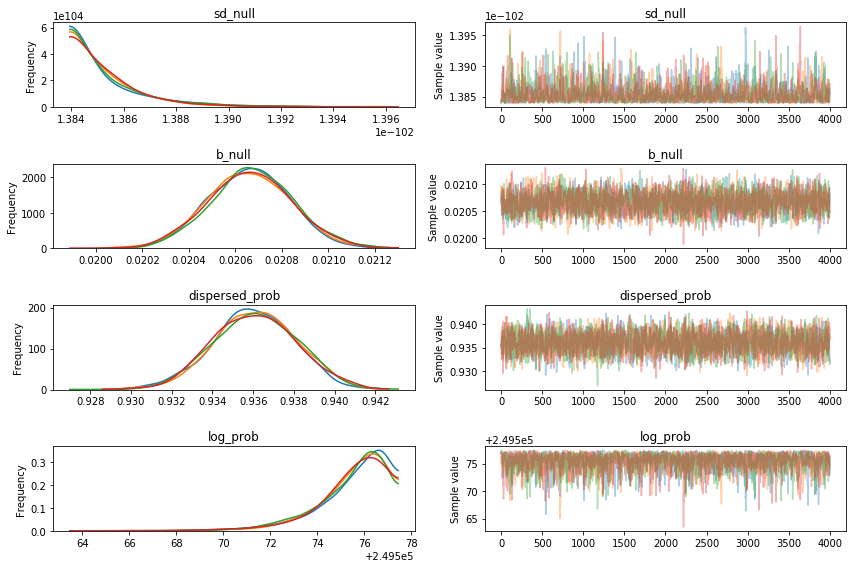

In [248]:
pm.traceplot(voa11543sa_mono_cd8_null['trace'])

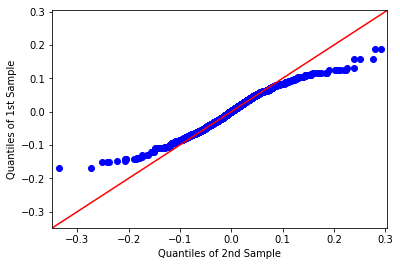

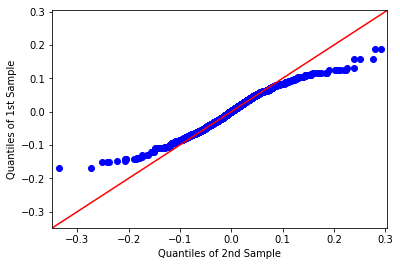

In [249]:
pred_samples = np.random.choice(voa11543sa_mono_cd8_null['ppc']['null'].flatten(), size = logfcs_same.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_same, line = '45')

## Fitting `splatter` model

In [250]:
voa11543sa_mono_cd8_splatter = splatter_model(logfcs_diff, logfcs_same, null_sd = 1e-50, null_b = 0.0206, null_dispersed_prob = 0.936, iter_count = 1000, tune_iters = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6474993b38>,
      dtype=object)

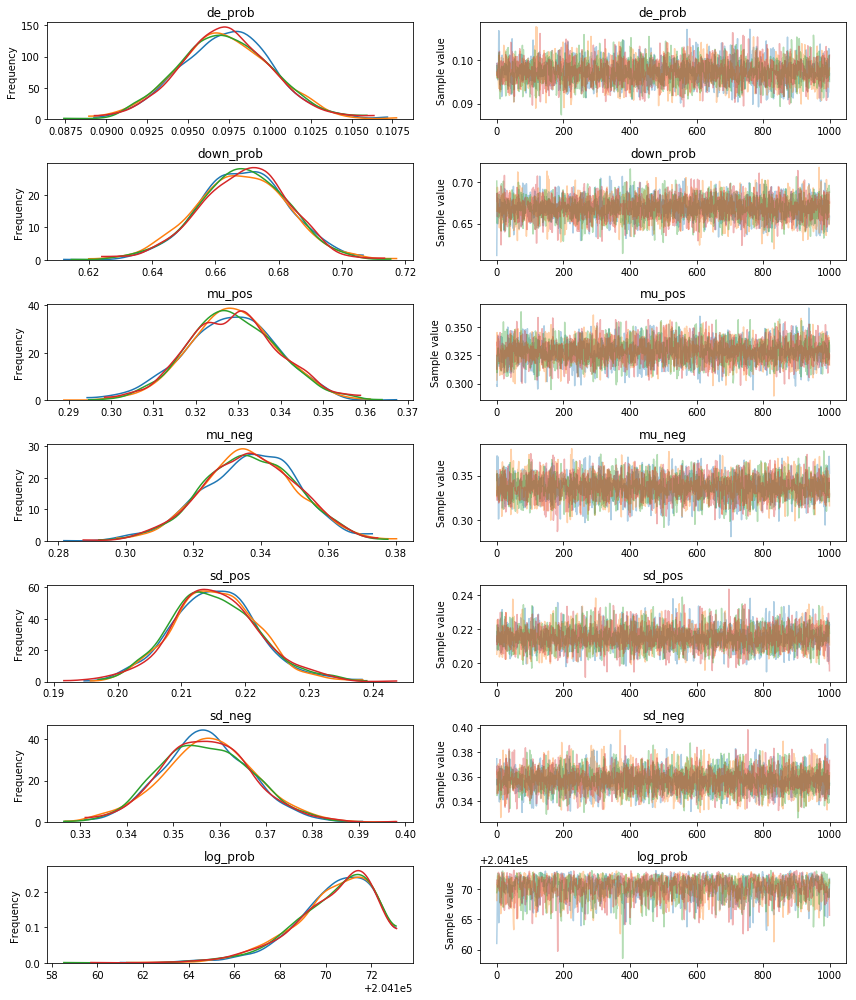

In [251]:
pm.traceplot(voa11543sa_mono_cd8_splatter['trace'])

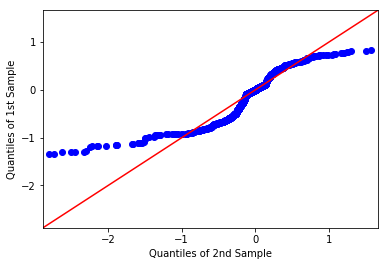

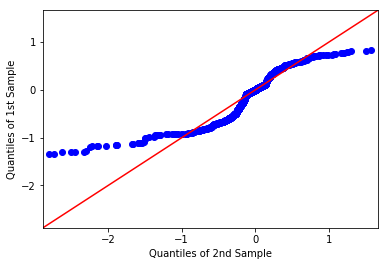

In [253]:
pred_samples = np.random.choice(voa11543sa_mono_cd8_splatter['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

## Fitting v2 model

In [254]:
voa11543sa_mono_cd8_v2 = v2_model(logfcs_diff, logfcs_same, null_sd = 1e-50, null_b = 0.0245, null_dispersed_prob = 0.91, iter_count = 2500, tune_iters = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 135554.94379225883


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs 61641.11438136264


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 2500/2500 [00:24<00:00, 100.59it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6479ef51d0>,
      dtype=object)

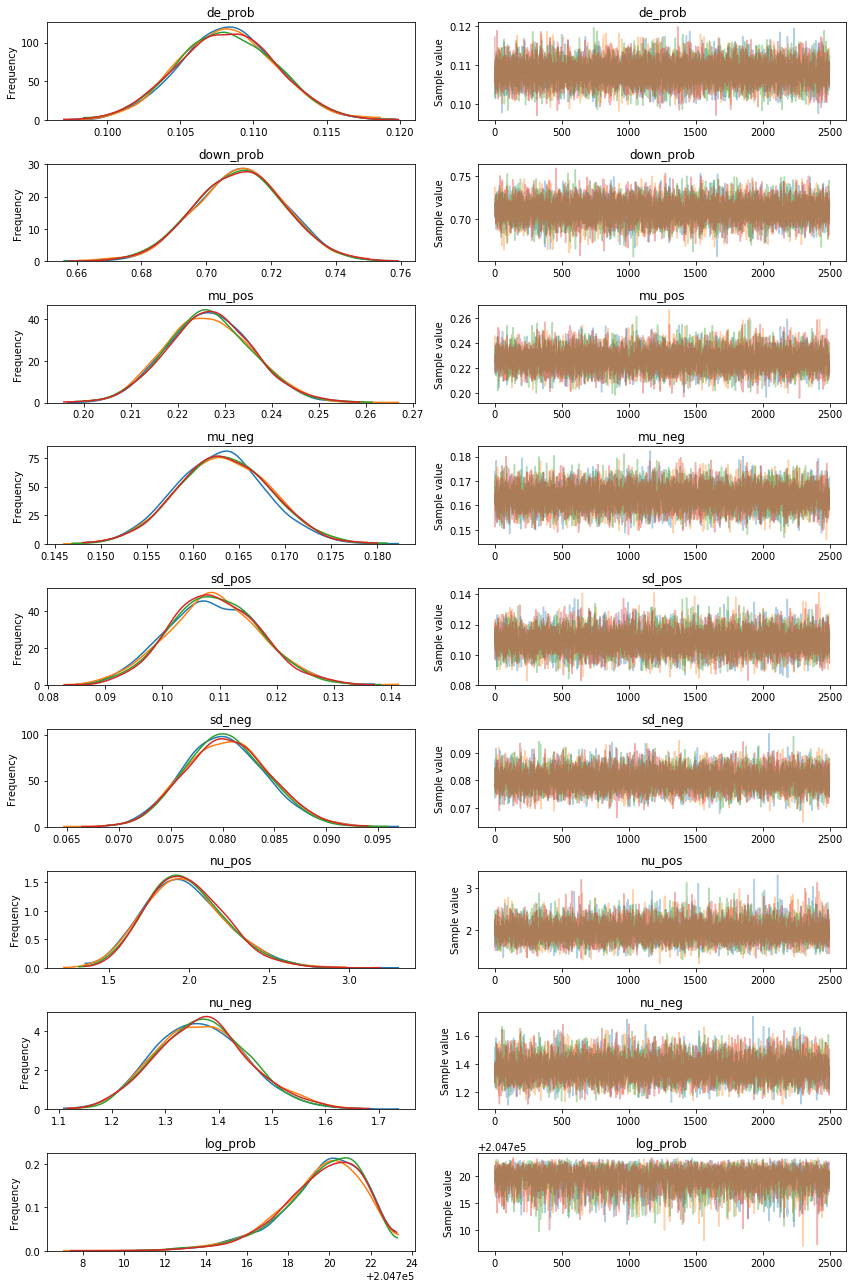

In [255]:
pm.traceplot(voa11543sa_mono_cd8_v2['trace'])

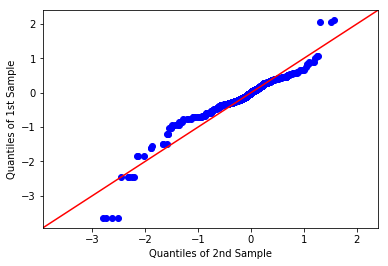

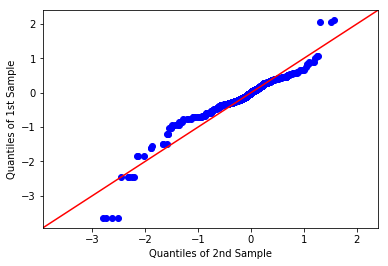

In [300]:
pred_samples = np.random.choice(voa11543sa_mono_cd8_v2['ppc']['obs'][1750:2500].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

## V3 model

In [180]:
voa11543sa_mono_cd8_v3 = v3_model(logfcs_diff, logfcs_same, null_sd = 1e-50, null_b = 0.0245, null_dispersed_prob = 0.91, 
                                  iter_count = 8000, tune_iters = 1000, max_fc = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 135554.94379225883


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs 61641.11438136264


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 8000/8000 [01:15<00:00, 105.39it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3ee11e710>,
      dtype=object)

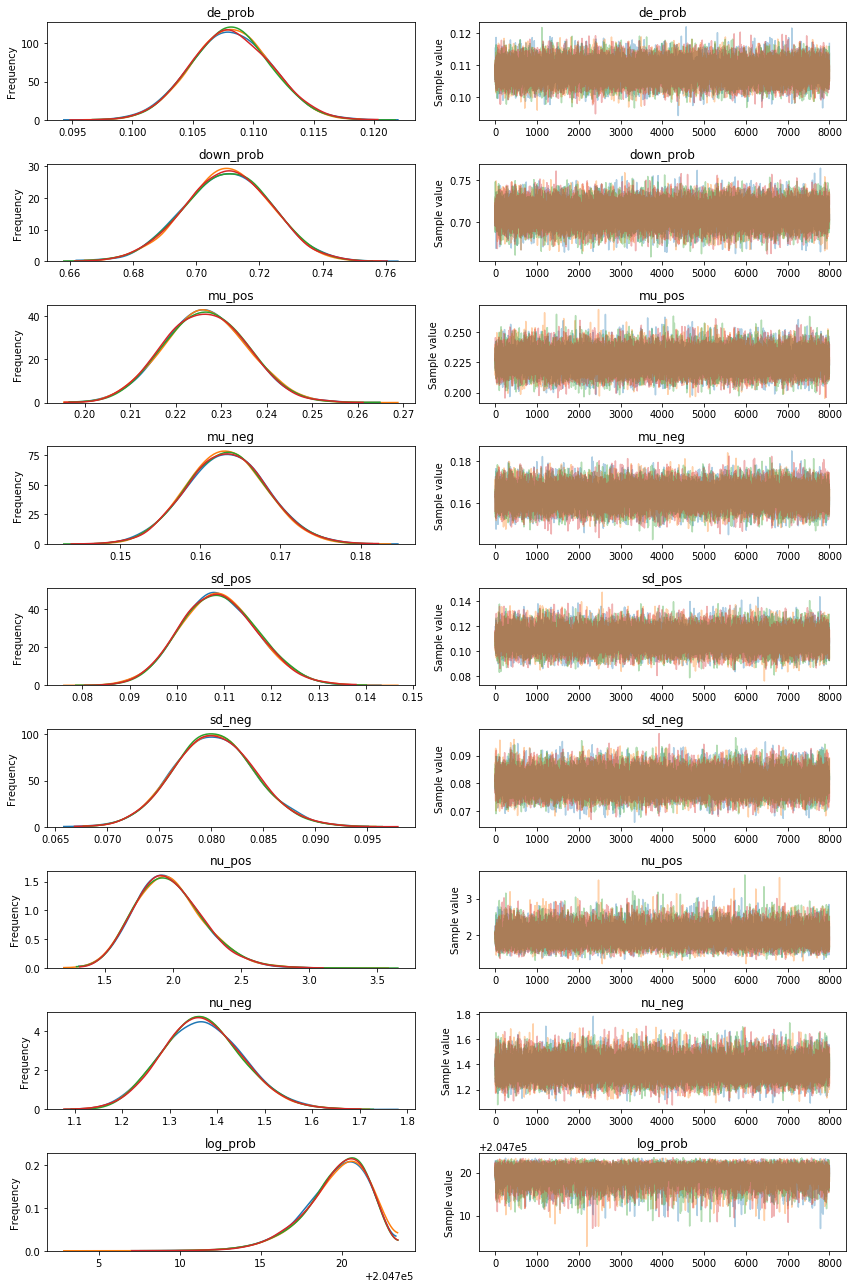

In [181]:
pm.traceplot(voa11543sa_mono_cd8_v3['trace'])

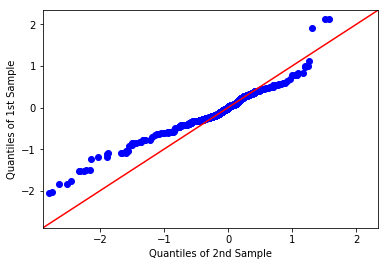

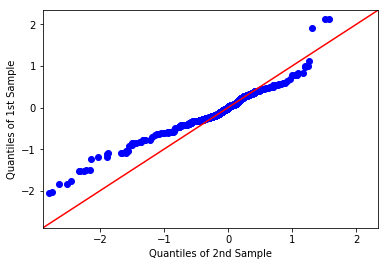

In [194]:
pred_samples = np.random.choice(voa11543sa_mono_cd8_v3['ppc']['obs'][7000:8000].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

# HGSC: Endothelial cells vs. fibroblasts/myofibroblasts

In [8]:
class1 = "Endothelial cells"
class2 = "Fibroblast/Myofibroblast"

logfcs_diff = get_logfcs_comparison(voa11543sa_markers, class1, class2)
logfcs_same = np.array(voa11543sa_null_logfcs[(voa11543sa_null_logfcs['celltype'] == class2) & (voa11543sa_null_logfcs['permutation'] == 1)].logfc)

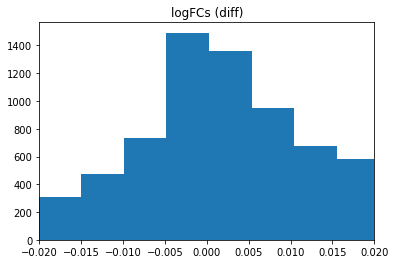

In [9]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

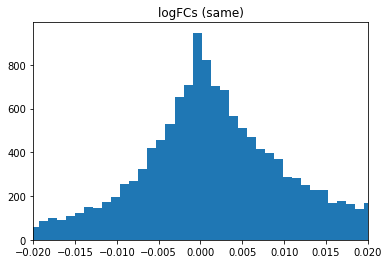

In [10]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

## Fitting null model

In [304]:
voa11543sa_endo_fibro_null = run_null_model(logfcs_same, iter_count=4000, tune_iters = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dispersed_prob, b_null, sd_null]
100%|██████████| 4000/4000 [00:10<00:00, 373.56it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f647012ef28>,
      dtype=object)

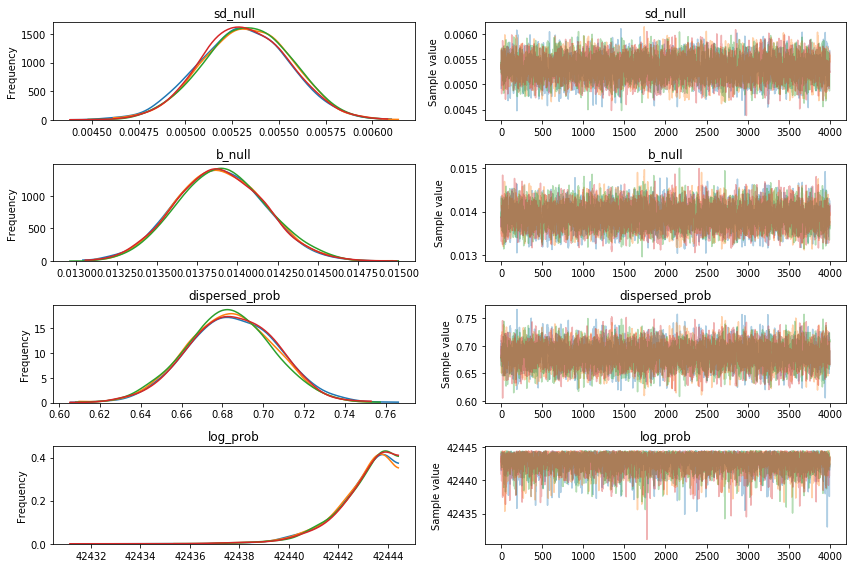

In [305]:
pm.traceplot(voa11543sa_endo_fibro_null['trace'])

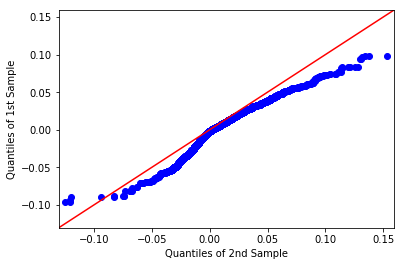

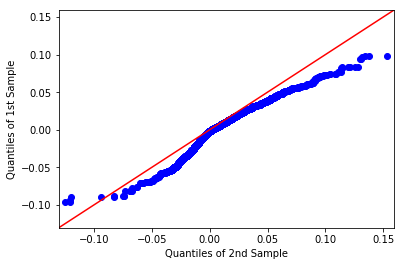

In [306]:
pred_samples = np.random.choice(voa11543sa_endo_fibro_null['ppc']['null'].flatten(), size = logfcs_same.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_same, line = '45')

## Fitting `splatter` model

In [307]:
voa11543sa_endo_fibro_splatter = splatter_model(logfcs_diff, logfcs_same, null_sd = 0.00525, null_b = 0.014, null_dispersed_prob = 0.68, iter_count = 1000, tune_iters = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 1000/1000 [00:25<00:00, 39.92it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64742007b8>,
      dtype=object)

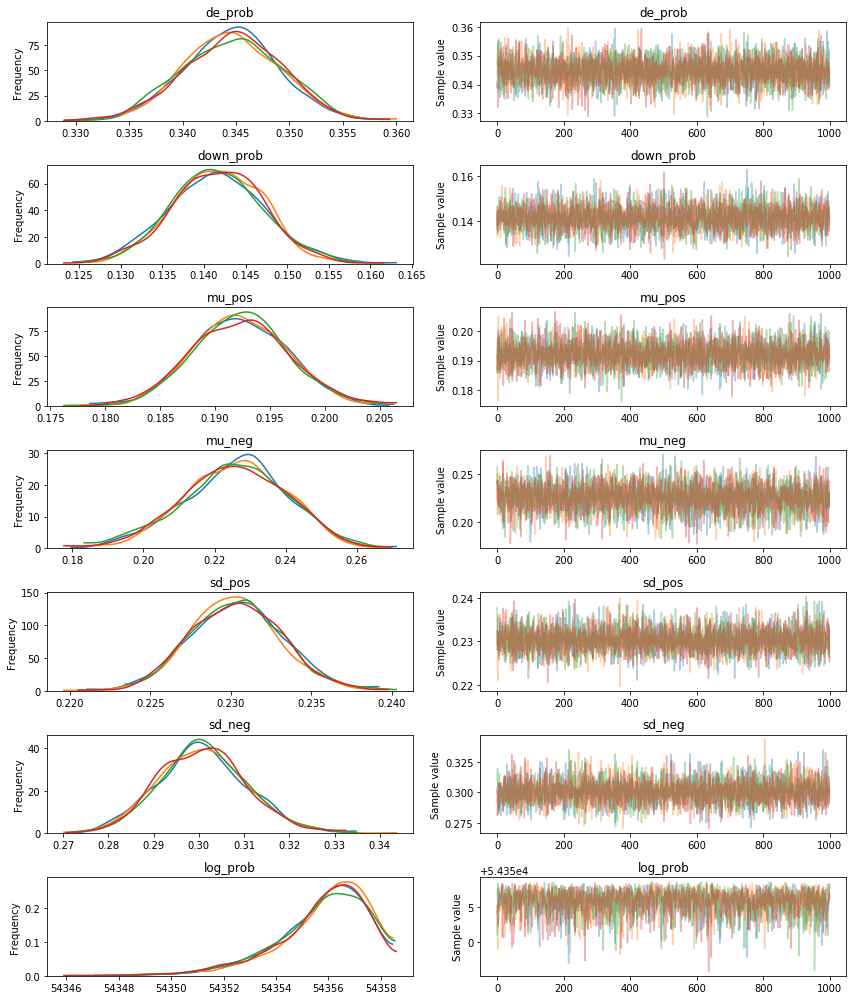

In [308]:
pm.traceplot(voa11543sa_endo_fibro_splatter['trace'])

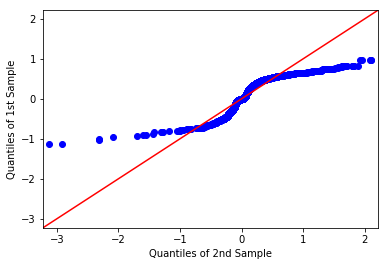

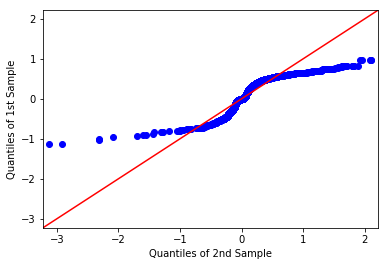

In [309]:
pred_samples = np.random.choice(voa11543sa_endo_fibro_splatter['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

## Fitting v2 model

In [310]:
voa11543sa_endo_fibro_v2 = v2_model(logfcs_diff, logfcs_same, null_sd = 0.00525, null_b = 0.014, null_dispersed_prob = 0.68, iter_count = 2500, tune_iters = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 42454.962715403046


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs -7910.243672125914


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 2500/2500 [00:24<00:00, 103.97it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f646de2d860>,
      dtype=object)

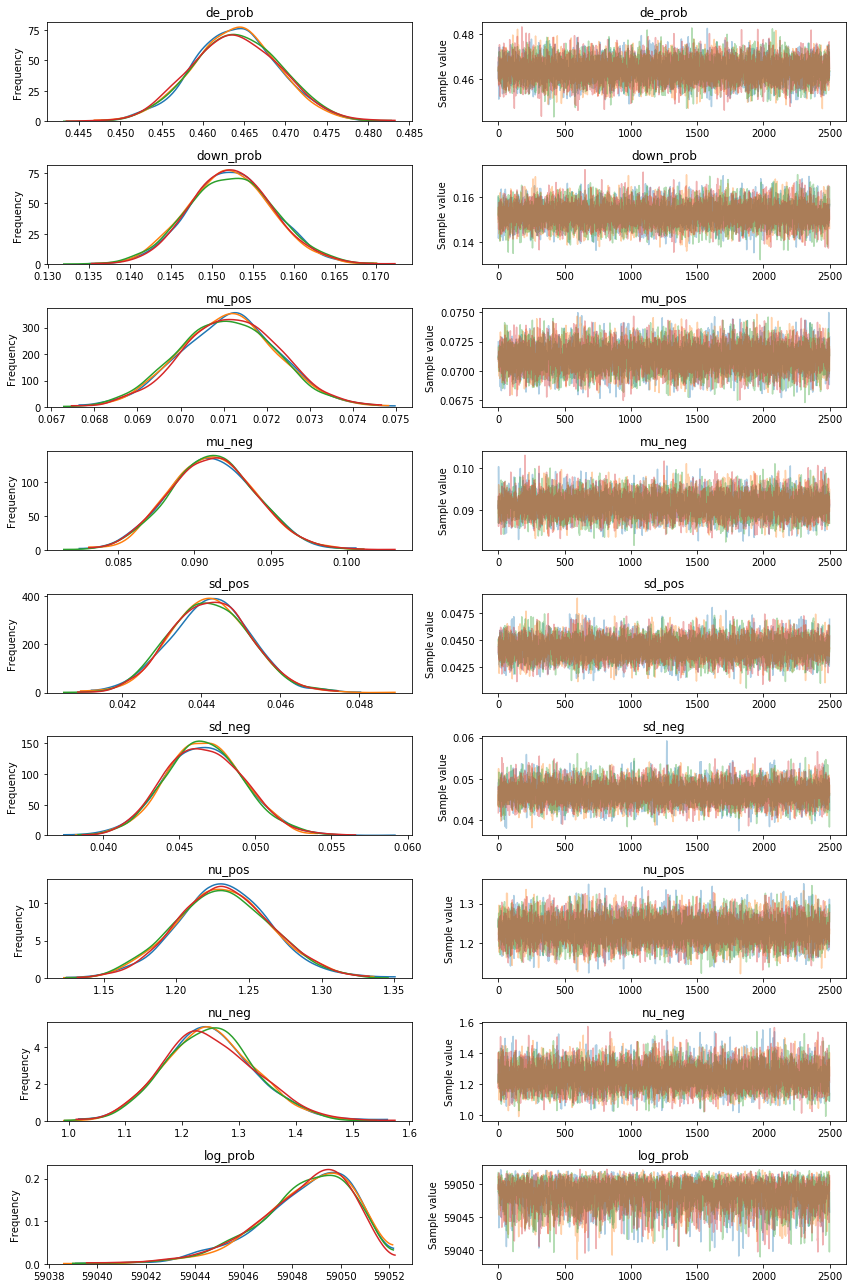

In [311]:
pm.traceplot(voa11543sa_endo_fibro_v2['trace'])

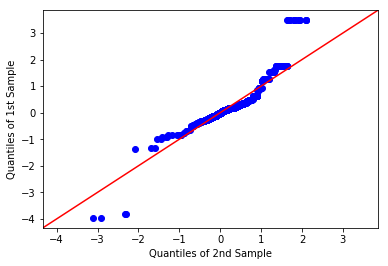

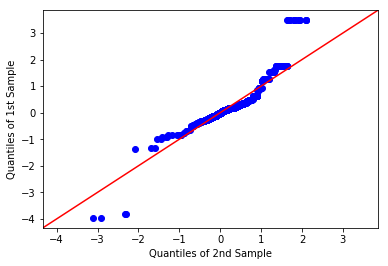

In [325]:
pred_samples = np.random.choice(voa11543sa_endo_fibro_v2['ppc']['obs'][2000:2500].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

## V3 model

In [11]:
voa11543sa_endo_fibro_v3 = v3_model(logfcs_diff, logfcs_same, null_sd = 0.00525, null_b = 0.014, null_dispersed_prob = 0.68, iter_count = 8000, 
                                    tune_iters = 1000, max_fc = 1000)

de_prob_logodds__ -1.093929310692946
down_prob_logodds__ -1.3862943611198906
mu_pos_log__ -0.9189385332046731
mu_neg_log__ -0.9189385332046731
sd_pos_log__ -4.655531579901902
sd_neg_log__ -4.655531579901902
nu_pos_log__ -0.1308642937254938
nu_neg_log__ -0.1308642937254938
null 42454.962715403046


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


obs -7910.243672125914


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_neg, nu_pos, sd_neg, sd_pos, mu_neg, mu_pos, down_prob, de_prob]
100%|██████████| 8000/8000 [01:17<00:00, 103.30it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb21a2eaf28>,
      dtype=object)

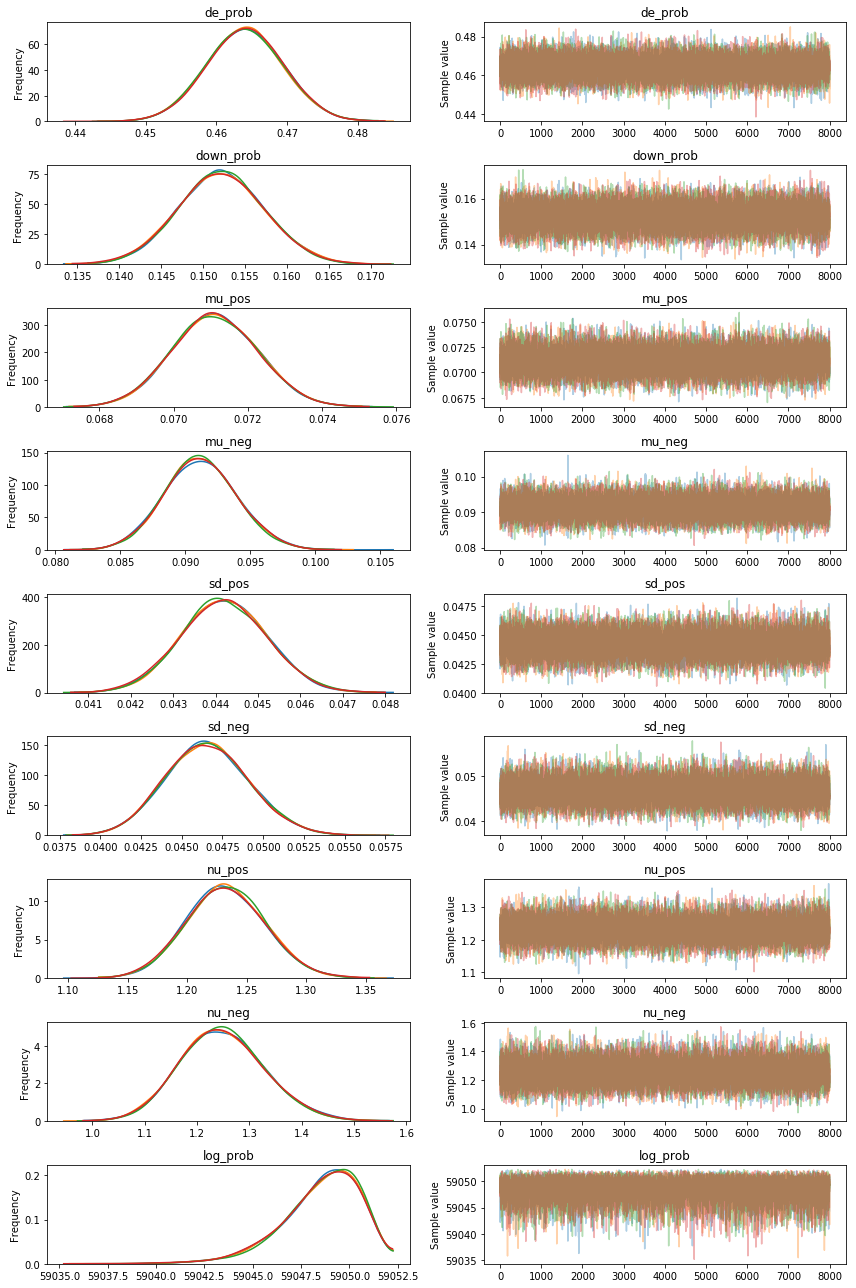

In [12]:
pm.traceplot(voa11543sa_endo_fibro_v3['trace'])

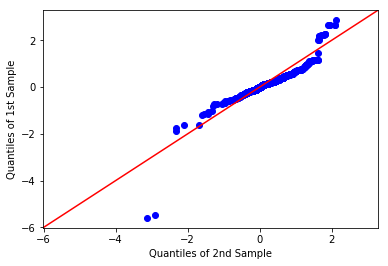

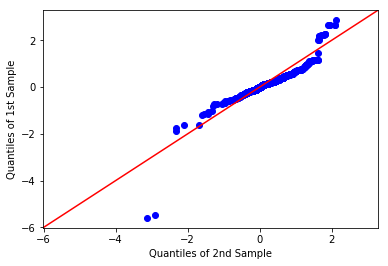

In [26]:
pred_samples = np.random.choice(voa11543sa_endo_fibro_v3['ppc']['obs'][6000:8000].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')